Jupiter info:
[I 15:17:36.542 NotebookApp] Writing notebook server cookie secret to /Users/roaringlion/Library/Jupyter/runtime/notebook_cookie_secret
[I 2024-11-03 15:18:02.461 LabApp] JupyterLab extension loaded from /Users/roaringlion/opt/anaconda3/lib/python3.9/site-packages/jupyterlab
[I 2024-11-03 15:18:02.461 LabApp] JupyterLab application directory is /Users/roaringlion/opt/anaconda3/share/jupyter/lab
[I 15:18:02.465 NotebookApp] Serving notebooks from local directory: /Users/roaringlion
[I 15:18:02.465 NotebookApp] Jupyter Notebook 6.4.8 is running at:
[I 15:18:02.465 NotebookApp] http://localhost:8888/?token=4ddb71791210fb8f3328574a16ae2016842ef08cd3bacaf4
[I 15:18:02.465 NotebookApp]  or http://127.0.0.1:8888/?token=4ddb71791210fb8f3328574a16ae2016842ef08cd3bacaf4
[I 15:18:02.465 NotebookApp] Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
[C 15:18:02.470 NotebookApp]

    To access the notebook, open this file in a browser:
        file:///Users/roaringlion/Library/Jupyter/runtime/nbserver-8980-open.html
    Or copy and paste one of these URLs:
        http://localhost:8888/?token=4ddb71791210fb8f3328574a16ae2016842ef08cd3bacaf4
     or http://127.0.0.1:8888/?token=4ddb71791210fb8f3328574a16ae2016842ef08cd3bacaf4


In [8]:
# Libraries:
import os
import json
import pandas as pd
import nltk
import re

# Uncomment the line below if nltk data is not already downloaded
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/roaringlion/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

creating all the cleaning:

In [9]:
# Define the directory containing JSON files
directory_path = "/Users/roaringlion/IdeaProjects/Article-Bias-Prediction/data/jsons"  # Replace with your local path

# Define a function to clean special characters in the text
def clean_text(text):
    text = re.sub(r'\u2014', '-', text)  # em dash
    text = re.sub(r'\u2013', '-', text)  # en dash
    text = re.sub(r'\u201c', '', text)  # left double quote
    text = re.sub(r'\u201d', '', text)  # right double quote
    text = re.sub(r'\u2018', "'", text)  # left single quote
    text = re.sub(r'\u2019', "'", text)  # right single quote
    text = re.sub(r'\u00ad', '-', text)  # soft hyphen
    text = re.sub(r'\u2026', '...', text)  # ellipsis
    text = re.sub(r'\u2122', 'TM', text)  # trademark symbol
    text = re.sub(r'\u00a0', ' ', text)  # non-breaking space
    text = re.sub(r'\u200b', '', text)    # zero-width space
    text = re.sub(r'\u2588', '', text)    # hidden space
    text = re.sub(r'\s+', ' ', text).strip()  # replace multiple spaces with a single space
    return text

# Initialize counters and lists for storing processed and skipped data
file_counter = 0
max_files = 37554  # Limit to the first 50 files
processed_data = []
skipped_files = []

# Process JSON files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)

        # Increment file count and check if it exceeds the limit
        file_counter += 1
        if file_counter > max_files:
            break

        # Reinitialize variables to ensure no carryover
        topic = None
        bias_text = None
        bias = None
        content = None
        title = None

        with open(file_path, 'r') as file:
            json_data = json.load(file)

        # Extract required fields
        topic = json_data.get("topic")
        bias_text = json_data.get("bias_text")
        bias = json_data.get("bias")
        content = json_data.get("content")
        title = json_data.get("title", "")

        # Check if all necessary fields are present
        if topic and bias_text and bias is not None and content:
            # Clean content and title
            content = clean_text(content)
            title = clean_text(title)

            # Split content into sentences, combining every two sentences per row
            sentences = nltk.sent_tokenize(content)
            for i in range(0, len(sentences), 2):
                combined_sentences = ' '.join(sentences[i:i + 2])

                # Append data to the main list
                processed_data.append({
                    "file_number": file_counter,
                    "file_name": filename,
                    "topic": topic,
                    "bias_text": bias_text,
                    "bias": bias,
                    "title": title,  # Cleaned title
                    "url": json_data.get("url", ""),
                    "content": combined_sentences
                })
        else:
            # Debugging output for missing data
            print(f"Skipping file: {filename}")
            print(f"  topic: {topic}")
            print(f"  bias_text: {bias_text}")
            print(f"  bias: {bias}")
            print(f"  content: {content[:100] if content else 'None'}...")  # Display only the first 100 characters of content
            # Track skipped files
            skipped_files.append(filename)

# Convert processed data to DataFrame and save as CSV
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv("/Users/roaringlion/IdeaProjects/Article-Bias-Prediction/data/combined_data.csv", index=False, encoding='utf-8')
print("Processed data saved to 'combined_data.csv'")

# Save skipped files with missing data to separate CSV for reference
skipped_df = pd.DataFrame({"skipped_files": skipped_files})
skipped_df.to_csv("/Users/roaringlion/IdeaProjects/Article-Bias-Prediction/data/skipped_files.csv", index=False)
print("Skipped files saved to 'skipped_files.csv'")


Processed data saved to 'combined_data.csv'
Skipped files saved to 'skipped_files.csv'


In [10]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794532 entries, 0 to 794531
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   file_number  794532 non-null  int64 
 1   file_name    794532 non-null  object
 2   topic        794532 non-null  object
 3   bias_text    794532 non-null  object
 4   bias         794532 non-null  int64 
 5   title        794532 non-null  object
 6   url          794532 non-null  object
 7   content      794532 non-null  object
dtypes: int64(2), object(6)
memory usage: 48.5+ MB


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [12]:
processed_df

,file_number,file_name,topic,bias_text,bias,title,url,content
0,1,bpp2Cqpvyi2ER5Lr.json,politics,left,0,Can the Impeachment Hearings Actually Change A...,https://www.politico.com/news/magazine/2019/11...,"This happens for different reasons , but a key..."
1,1,bpp2Cqpvyi2ER5Lr.json,politics,left,0,Can the Impeachment Hearings Actually Change A...,https://www.politico.com/news/magazine/2019/11...,Consuming more belief-consistent information w...
2,1,bpp2Cqpvyi2ER5Lr.json,politics,left,0,Can the Impeachment Hearings Actually Change A...,https://www.politico.com/news/magazine/2019/11...,"Except , maybe . One of the more interesting f..."
3,1,bpp2Cqpvyi2ER5Lr.json,politics,left,0,Can the Impeachment Hearings Actually Change A...,https://www.politico.com/news/magazine/2019/11...,"Typically , when others try to change our view..."
4,1,bpp2Cqpvyi2ER5Lr.json,politics,left,0,Can the Impeachment Hearings Actually Change A...,https://www.politico.com/news/magazine/2019/11...,"Over time , when we are exposed to information..."
...,...,...,...,...,...,...,...,...
794527,37554,3BMrcnVjf3C8Rsgz.json,us_congress,right,2,McConnell rails against Mueller report politic...,https://www.foxnews.com/politics/mcconnell-rai...,"Democrats , though , maintain there 's still m..."
794528,37554,3BMrcnVjf3C8Rsgz.json,us_congress,right,2,McConnell rails against Mueller report politic...,https://www.foxnews.com/politics/mcconnell-rai...,`` Our leader saying let 's move on is sort of...
794529,37554,3BMrcnVjf3C8Rsgz.json,us_congress,right,2,McConnell rails against Mueller report politic...,https://www.foxnews.com/politics/mcconnell-rai...,In the hours prior to the report 's release to...
794530,37554,3BMrcnVjf3C8Rsgz.json,us_congress,right,2,McConnell rails against Mueller report politic...,https://www.foxnews.com/politics/mcconnell-rai...,HUNDREDS OF EX-PROSECUTORS CLAIM TRUMP WOULD H...


In [13]:
import seaborn as sns

1) Now the goal will be to create some descriptive statistics:
Bias distribution (bias_text) by topics, as well as amount of topics.

2) Average sentence lenght by bias.

In [14]:
import matplotlib.pyplot as plt

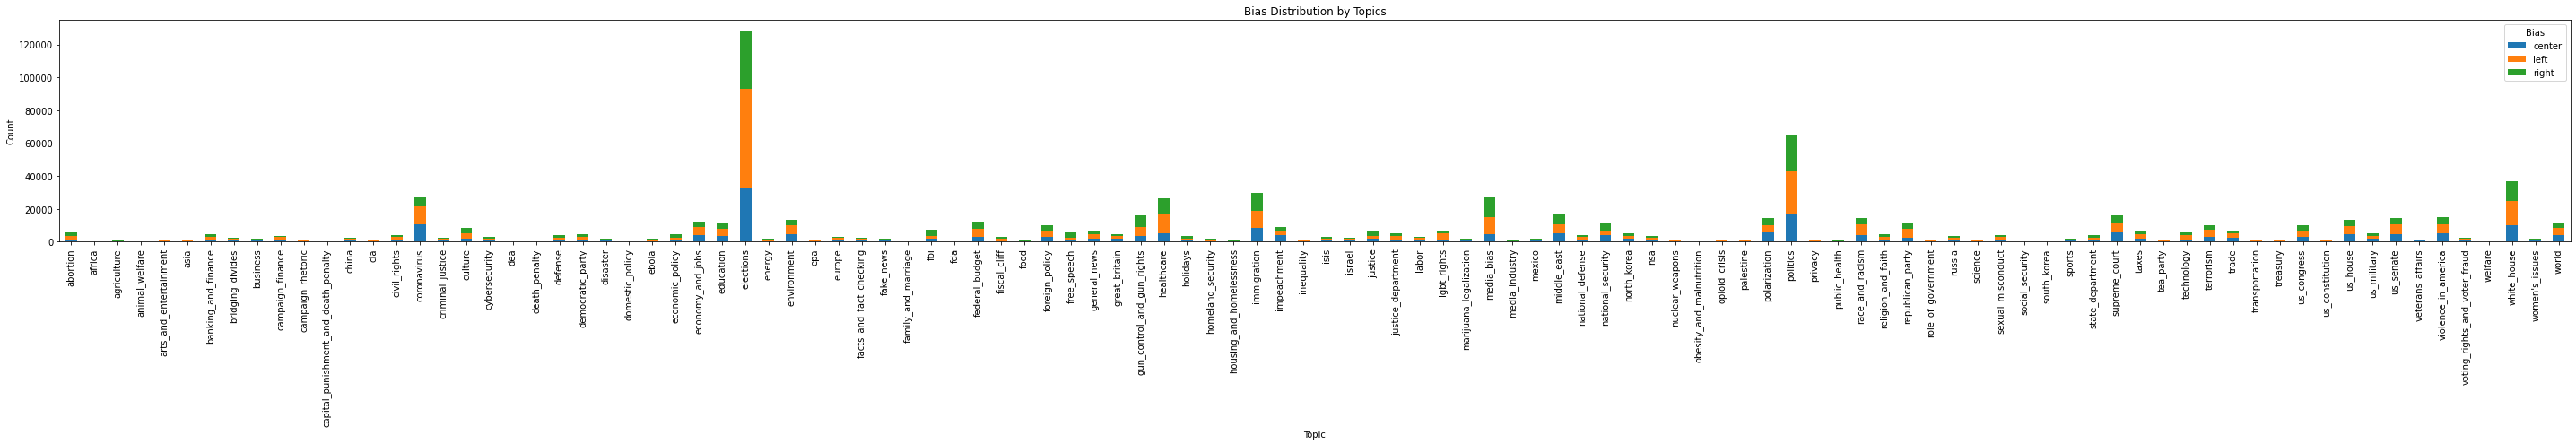

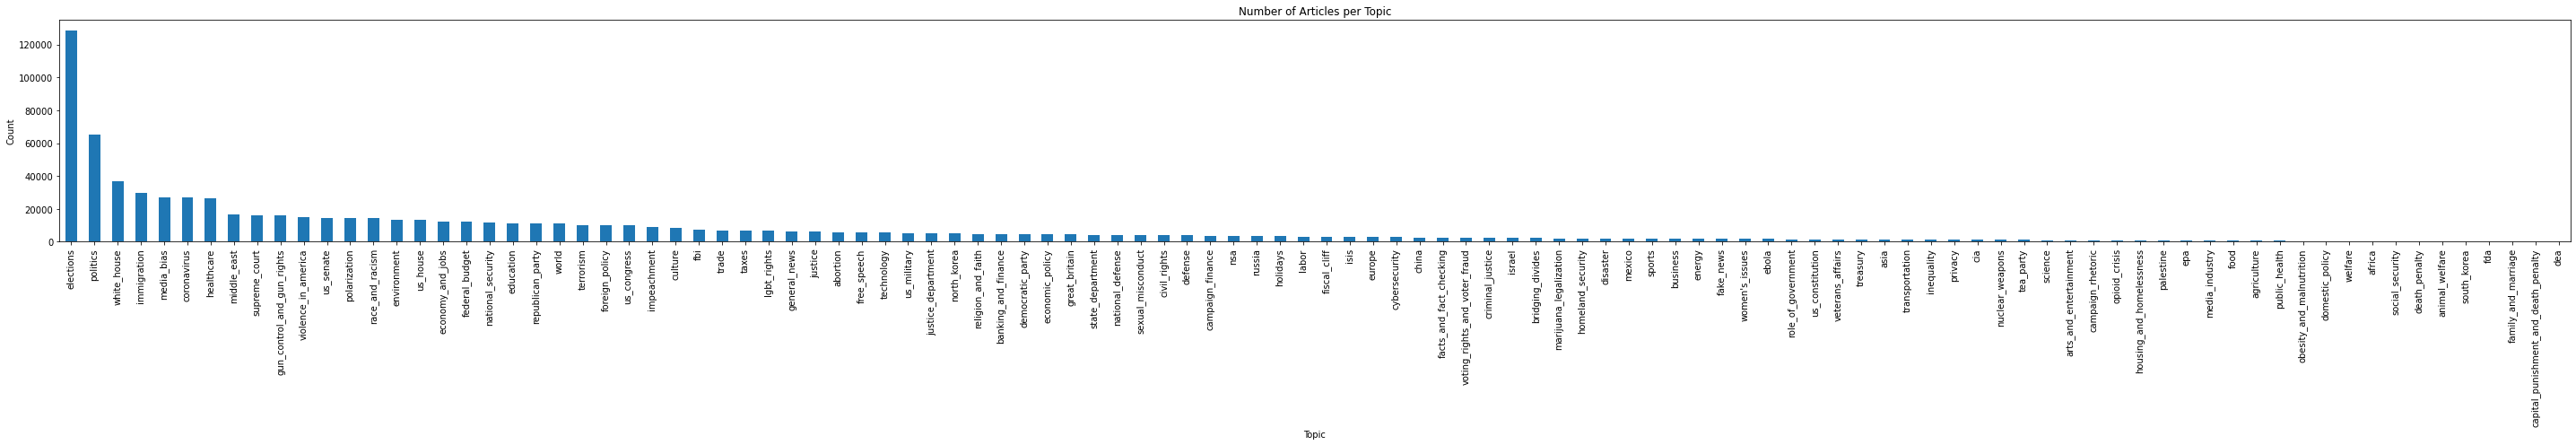

In [15]:
# Ensure columns needed for analysis are present
required_columns = ['topic', 'bias_text']

# 1. Bias Distribution by Topics
bias_topic_counts = processed_df.groupby(['topic', 'bias_text']).size().unstack().fillna(0)

# Plot the bias distribution by topics (stacked bar chart)
bias_topic_counts.plot(kind='bar', stacked=True, figsize=(40, 7))
plt.title("Bias Distribution by Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(title="Bias")
plt.tight_layout()
plt.show()

# 2. Number of Topics
topic_counts = processed_df['topic'].value_counts()

# Plot the number of articles per topic
topic_counts.plot(kind='bar', figsize=(40, 7))
plt.title("Number of Articles per Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [16]:
# Get unique titles directly from the DataFrame
unique_topics = processed_df['topic'].drop_duplicates().tolist()

# Display or print the list of unique titles
print(unique_topics)

['politics', 'china', 'terrorism', 'nsa', 'capital_punishment_and_death_penalty', 'elections', 'coronavirus', 'white_house', 'us_house', 'federal_budget', 'world', 'education', 'immigration', 'impeachment', 'middle_east', 'democratic_party', 'supreme_court', 'race_and_racism', 'republican_party', 'us_senate', 'violence_in_america', 'economy_and_jobs', 'healthcare', 'food', 'palestine', 'media_bias', 'justice_department', 'privacy', 'lgbt_rights', 'economic_policy', 'disaster', 'great_britain', 'taxes', 'general_news', 'veterans_affairs', 'asia', 'epa', 'welfare', 'gun_control_and_gun_rights', 'foreign_policy', 'us_congress', 'us_military', 'polarization', 'environment', 'labor', 'defense', 'abortion', 'opioid_crisis', 'national_security', 'bridging_divides', 'technology', 'state_department', 'fbi', 'trade', 'energy', 'europe', 'cia', 'inequality', 'free_speech', 'sexual_misconduct', 'campaign_finance', 'culture', 'transportation', 'mexico', 'banking_and_finance', 'israel', 'religion_an

From all topics: 'politics', 'china', 'terrorism', 'nsa', 'capital_punishment_and_death_penalty', 'elections', 'coronavirus', 'white_house', 'us_house', 'federal_budget', 'world', 'education', 'immigration', 'impeachment', 'middle_east', 'democratic_party', 'supreme_court', 'race_and_racism', 'republican_party', 'us_senate', 'violence_in_america', 'economy_and_jobs', 'healthcare', 'food', 'palestine', 'media_bias', 'justice_department', 'privacy', 'lgbt_rights', 'economic_policy', 'disaster', 'great_britain', 'taxes', 'general_news', 'veterans_affairs', 'asia', 'epa', 'welfare', 'gun_control_and_gun_rights', 'foreign_policy', 'us_congress', 'us_military', 'polarization', 'environment', 'labor', 'defense', 'abortion', 'opioid_crisis', 'national_security', 'bridging_divides', 'technology', 'state_department', 'fbi', 'trade', 'energy', 'europe', 'cia', 'inequality', 'free_speech', 'sexual_misconduct', 'campaign_finance', 'culture', 'transportation', 'mexico', 'banking_and_finance', 'israel', 'religion_and_faith', 'sports', 'us_constitution', 'isis', 'north_korea', 'homeland_security', 'national_defense', 'justice', 'campaign_rhetoric', 'russia', 'treasury', 'voting_rights_and_voter_fraud', 'facts_and_fact_checking', 'criminal_justice', 'civil_rights', 'media_industry', 'domestic_policy', "women's_issues", 'fiscal_cliff', 'holidays', 'arts_and_entertainment', 'marijuana_legalization', 'fake_news', 'tea_party', 'cybersecurity', 'nuclear_weapons', 'role_of_government', 'animal_welfare', 'agriculture', 'business', 'housing_and_homelessness', 'africa', 'ebola', 'science', 'fda', 'public_health', 'death_penalty', 'family_and_marriage', 'social_security', 'south_korea', 'dea', 'obesity_and_malnutrition'

The following ones seem to be not as interesting if we want to process worldwide data:
fbi, white_house, us_house, impeachment, republican_party, us_senate, violence_in_america, veterans_affairs, us_congress, gun_control_and_gun_rights, homeland_security, tea_party

This is why we might should throw them.

In [17]:
# List of topics to exclude
excluded_topics = [
    'fbi', 'white_house', 'us_house', 'impeachment', 'republican_party',
    'us_senate', 'violence_in_america', 'veterans_affairs', 'us_congress',
    'gun_control_and_gun_rights', 'homeland_security', 'tea_party'
]

# Filter out rows with excluded topics
filtered_df = processed_df[~processed_df['topic'].isin(excluded_topics)]

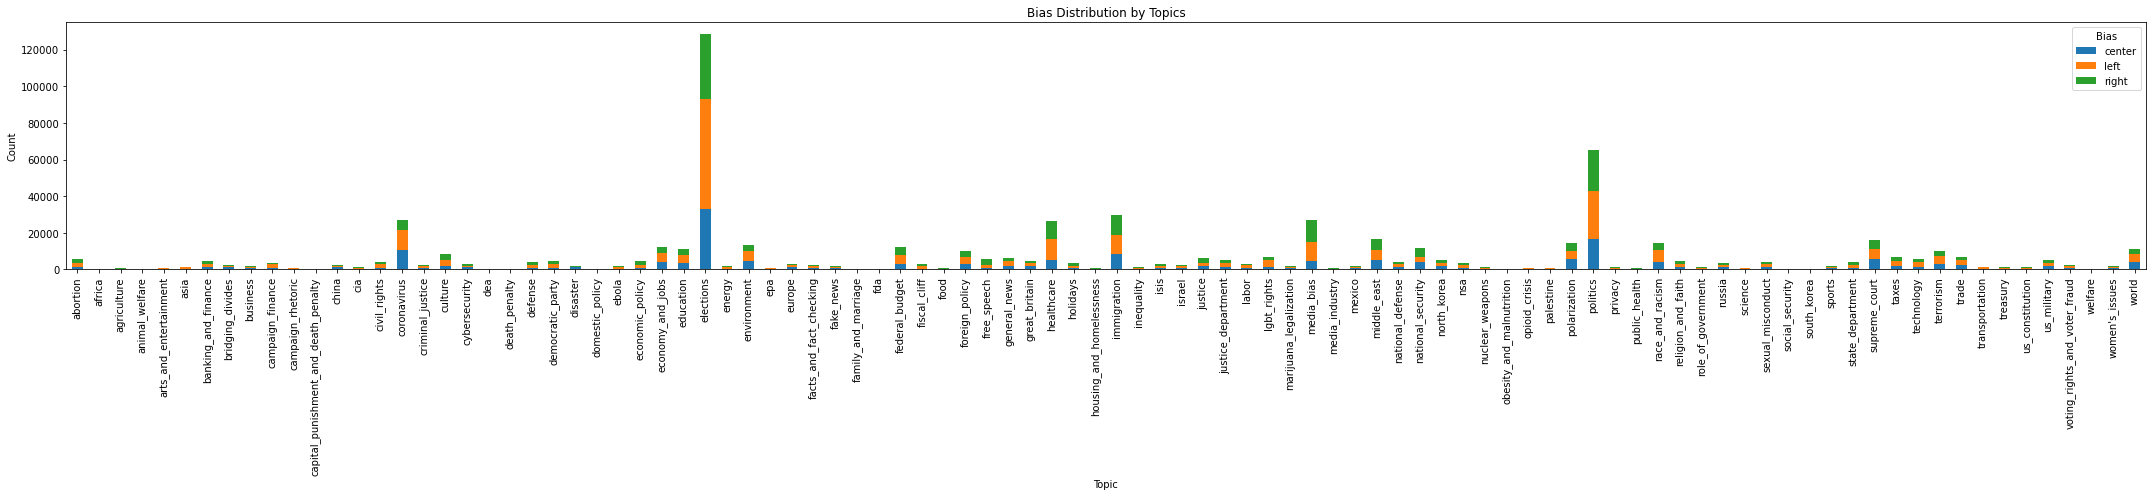

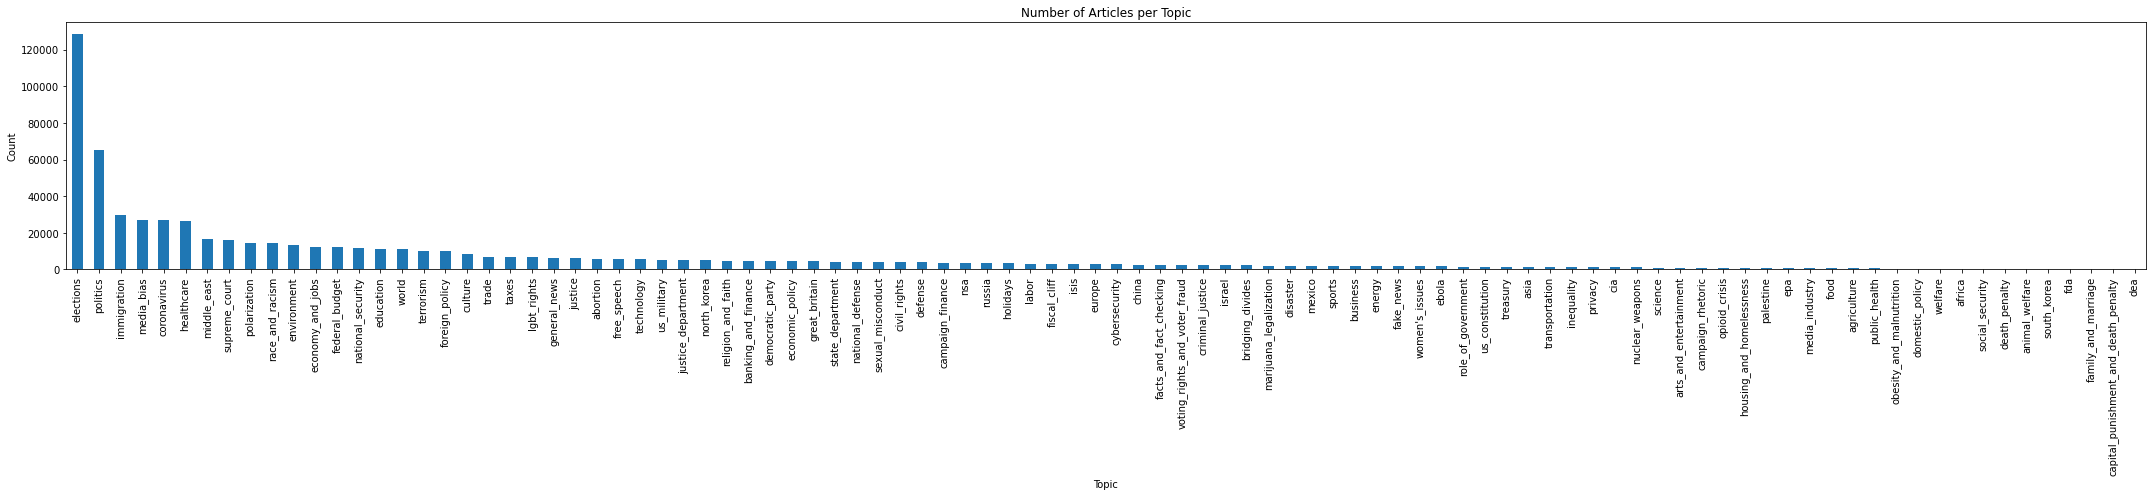

In [18]:
# Ensure columns needed for analysis are present
required_columns = ['topic', 'bias_text']

# 1. Bias Distribution by Topics
bias_topic_counts = filtered_df.groupby(['topic', 'bias_text']).size().unstack().fillna(0)

# Plot the bias distribution by topics (stacked bar chart)
bias_topic_counts.plot(kind='bar', stacked=True, figsize=(30, 7))
plt.title("Bias Distribution by Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(title="Bias")
plt.tight_layout()
plt.show()

# 2. Number of Topics
topic_counts = filtered_df['topic'].value_counts()

# Plot the number of articles per topic
topic_counts.plot(kind='bar', figsize=(30, 7))
plt.title("Number of Articles per Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

As we can see, elections, politics, white_house, immigration, media_bias, coronavirus, healthcare have the highhest amounts of sentences.
Elections is then also being mentioned mostly by the left, also coronavirus, politics and healthcare and media_bias are skewing.

In [19]:
# Count distribution of sentences by topic and bias
topic_bias_counts = filtered_df.groupby(['topic', 'bias_text']).size().unstack(fill_value=0)

# Display the largest topic-bias combinations
print("\nTop topics by bias distribution:")
print(topic_bias_counts.loc[topic_counts.head(10).index])  # Only showing top topics for readability


Top topics by bias distribution:
bias_text        center   left  right
elections         32744  60256  35421
politics          16803  26043  22616
immigration        8324  10442  10751
media_bias         4561  10520  12007
coronavirus       10387  11061   5298
healthcare         5276  11421   9587
middle_east        4878   5706   5822
supreme_court      5662   5382   5241
polarization       5767   4398   4182
race_and_racism    3867   6821   3516


In [21]:
# Define the specific topics you want to balance
top_10_topics = [
    'elections', 'politics', 'immigration', 'media_bias', 'coronavirus', 'healthcare', 'middle_east',
    'supreme_court', 'polarization', 'race_and_racism'
]
target_sample_size = 3000

# Initialize lists to store the sampled and unsampled data
sampled_data = []
unsampled_data = []

# Separate data for top 10 topics and others
top_10_df = filtered_df[filtered_df['topic'].isin(top_10_topics)]
other_topics_df = filtered_df[~filtered_df['topic'].isin(top_10_topics)]

# Sample each top 10 topic by bias
for (topic, bias), group in top_10_df.groupby(['topic', 'bias_text']):
    # Sample min(target_sample_size, len(group)) to avoid errors if there are fewer rows than the target
    sampled_group = group.sample(n=min(target_sample_size, len(group)), random_state=42)
    sampled_data.append(sampled_group)

# Combine the sampled data with the unmodified data for other topics
balanced_df = pd.concat(sampled_data + [other_topics_df]).reset_index(drop=True)

# Verify the new distribution for top 10 topics
balanced_topic_bias_counts = balanced_df[balanced_df['topic'].isin(top_10_topics)].groupby(['topic', 'bias_text']).size().unstack(fill_value=0)
print("\nBalanced topics by bias distribution (approx. 3,000 per top topic):")
print(balanced_topic_bias_counts)

# Check total count per topic for top 10 and other topics
balanced_topic_counts = balanced_df['topic'].value_counts()
print("\nTotal sentence counts per topic (top 10 balanced, others unchanged):")
print(balanced_topic_counts)


Balanced topics by bias distribution (approx. 3,000 per top topic):
bias_text        center  left  right
topic                               
coronavirus        3000  3000   3000
elections          3000  3000   3000
healthcare         3000  3000   3000
immigration        3000  3000   3000
media_bias         3000  3000   3000
middle_east        3000  3000   3000
polarization       3000  3000   3000
politics           3000  3000   3000
race_and_racism    3000  3000   3000
supreme_court      3000  3000   3000

Total sentence counts per topic (top 10 balanced, others unchanged):
environment                             13207
economy_and_jobs                        12407
federal_budget                          11970
national_security                       11497
education                               11308
                                        ...  
south_korea                               257
fda                                       248
family_and_marriage                       228
cap

In [22]:
balanced_df.sample(10)

,file_number,file_name,topic,bias_text,bias,title,url,content
180687,11399,mButNiotjx5Kfr5d.json,obesity_and_malnutrition,right,2,California bill would require warning labels o...,http://www.foxnews.com/politics/2014/02/14/cal...,He said the labeling would be consistent with ...
378097,37096,pvfcp9v5OdH7ruJs.json,national_security,center,1,"Life after Mueller: How Trump, Democrats, and ...",https://www.csmonitor.com/USA/Politics/2019/03...,It doesn ' t mean we shouldn ' t find out wher...
97394,849,yMT0MUFSXky3b2FN.json,taxes,left,0,Donald Trump is fumbling his real chance at ta...,https://www.vox.com/2017/4/27/15440378/trumps-...,He thinks the plan might generate about $ 1 tr...
35724,16105,KqKghIcHyubifZBV.json,immigration,right,2,How California's AG Responded to Officials Who...,https://townhall.com/tipsheet/leahbarkoukis/20...,It ' s a public safety issue to me . It ' s no...
182395,11627,POFI8pXOcpFfxpc2.json,foreign_policy,left,0,Donald Trump is vulnerable on China. So is Joe...,https://www.vox.com/2020/6/29/21303521/2020-el...,They should ' ve seen China ' s rise as a ques...
256286,21269,D4kFLxBL0Fs0ahBe.json,economy_and_jobs,left,0,How new research is shaking up the debate abou...,https://www.vox.com/2019/5/8/18528098/national...,"The academic debate isn ' t over , obviously ...."
331844,31234,UeuHnnUNoFlKMmUt.json,sexual_misconduct,center,1,Pope publicly acknowledges clergy sexual abuse...,https://www.apnews.com/397f2c76afc04532908035a...,Pope Francis receives a gift from a journalist...
15032,1556,MmIpmFKhTHDNMqF2.json,elections,right,2,Sandy-Fueled Superstorm Is October Surprise in...,http://www.newsmax.com/Newsfront/hurricane-san...,My first priority has to be to make sure that ...
354358,34140,EolNlGAz2fvmKv02.json,trade,left,0,Trump could hit a brick wall on NAFTA,http://www.politico.com/story/2016/12/donald-t...,"Meanwhile , whatever Trump decides to do on NA..."
2710,18032,CGjtOVX969ozD1UK.json,coronavirus,center,1,Coronavirus: Dexamethasone proves first life-s...,https://www.bbc.com/news/health-53061281,"So far , the only other drug proven to benefit..."


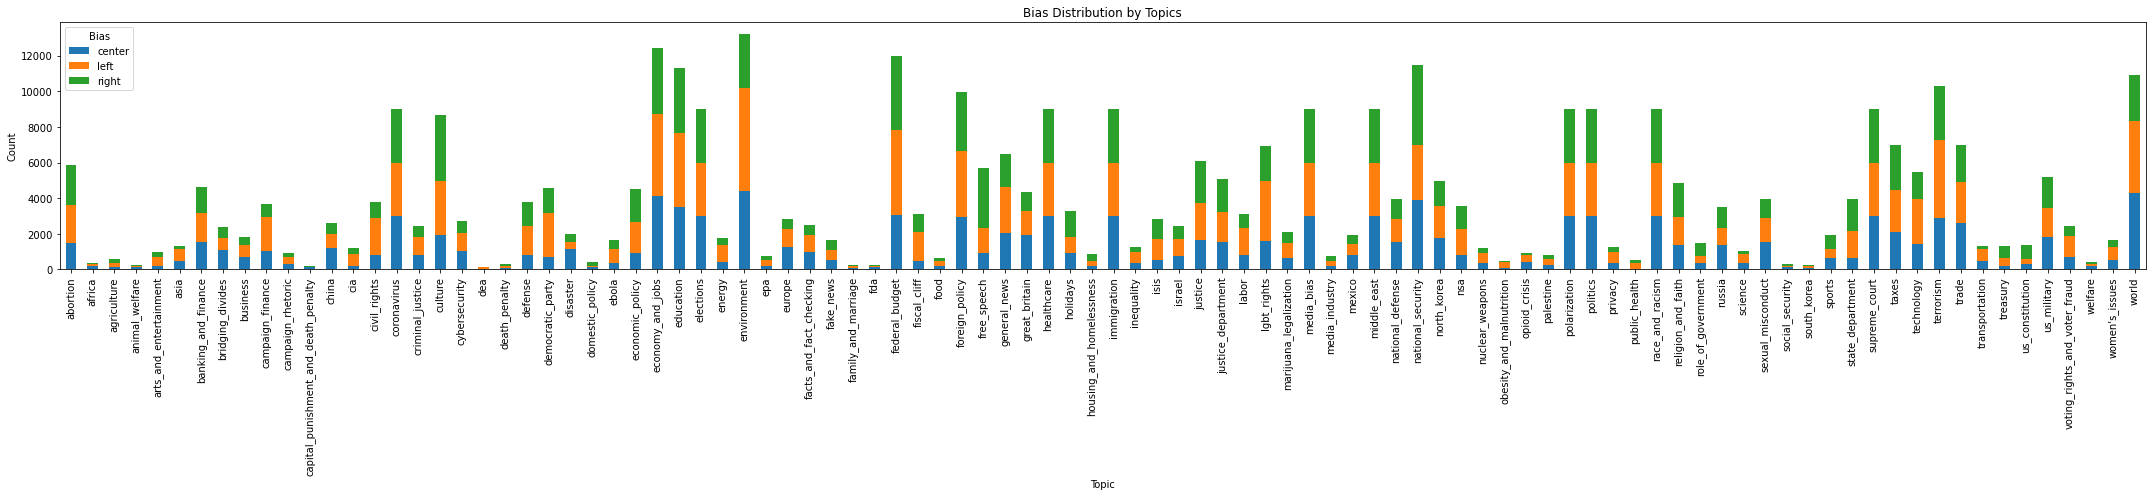

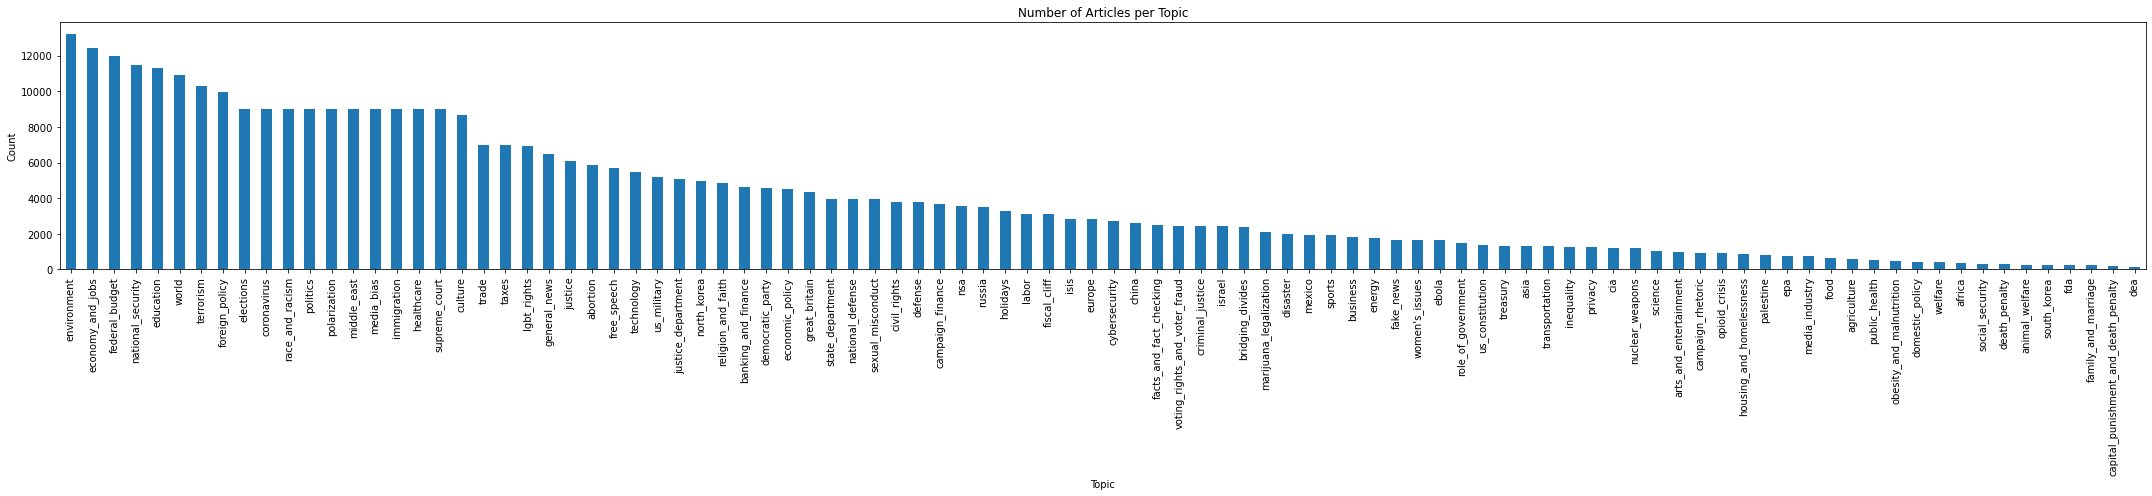

In [25]:
# Ensure columns needed for analysis are present
required_columns = ['topic', 'bias_text']

# 1. Bias Distribution by Topics
bias_topic_counts = balanced_df.groupby(['topic', 'bias_text']).size().unstack().fillna(0)

# Plot the bias distribution by topics (stacked bar chart)
bias_topic_counts.plot(kind='bar', stacked=True, figsize=(30, 7))
plt.title("Bias Distribution by Topics")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(title="Bias")
plt.tight_layout()
plt.show()

# 2. Number of Topics
topic_counts = balanced_df['topic'].value_counts()

# Plot the number of articles per topic
topic_counts.plot(kind='bar', figsize=(30, 7))
plt.title("Number of Articles per Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

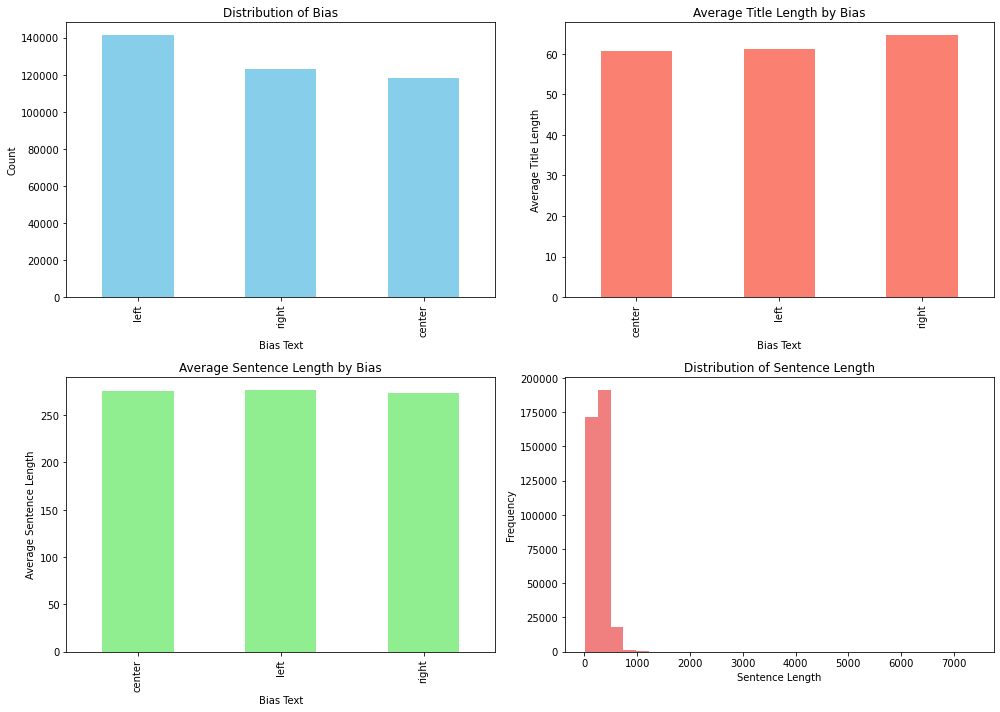

In [26]:
# Calculate title and sentence lengths
balanced_df['title_length'] = balanced_df['title'].apply(len)
balanced_df['sentence_length'] = balanced_df['content'].apply(len)

# Set up the figure for multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot bias distribution
balanced_df['bias_text'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Bias')
axes[0, 0].set_xlabel('Bias Text')
axes[0, 0].set_ylabel('Count')

# Plot average title length by bias
balanced_df.groupby('bias_text')['title_length'].mean().plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Average Title Length by Bias')
axes[0, 1].set_xlabel('Bias Text')
axes[0, 1].set_ylabel('Average Title Length')

# Plot average sentence length by bias
balanced_df.groupby('bias_text')['sentence_length'].mean().plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Average Sentence Length by Bias')
axes[1, 0].set_xlabel('Bias Text')
axes[1, 0].set_ylabel('Average Sentence Length')

# Plot distribution of sentence length across all sentences
balanced_df['sentence_length'].plot(kind='hist', bins=30, ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_title('Distribution of Sentence Length')
axes[1, 1].set_xlabel('Sentence Length')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Distribution of this seems okay.

Now let's do the encoding:
#### **Ordinal Encoding**
Ordinal encoding is used when the categorical values have an **intrinsic order** or ranking. In this technique, each category is assigned a unique integer based on its order. For example, if we have a feature `education` with values `high school`, `bachelor`, and `master`, we might assign:
- `high school` = 1
- `bachelor` = 2
- `master` = 3

This method is appropriate when the order of categories carries meaningful information.

#### **Label Encoding**
Label encoding is similar to ordinal encoding, but it can be used when there is **no intrinsic order** among the categories. It assigns each category a unique integer, but the numbers do not represent any kind of rank or order. For instance, the feature `who` with values `man`, `woman`, and `child` can be encoded as:
- `man` = 0
- `woman` = 1
- `child` = 2

This technique is useful for algorithms that can work with arbitrary numerical representations of categories.

#### **One-hot Encoding**
One-hot encoding transforms each category into a **binary vector**. Each category gets its own column, and the value is set to `1` in the column corresponding to the category, and `0` elsewhere. This is often used for features where categories have no inherent order, and the machine learning model should not assume any ranking.

For example, for the feature `who`, one-hot encoding would result in three new columns:
- **`who_man`**: 1 if the person is a man, 0 otherwise.
- **`who_woman`**: 1 if the person is a woman, 0 otherwise.
- **`who_child`**: 1 if the person is a child, 0 otherwise.

### Comparison of Techniques:
- **Ordinal Encoding** and **Label Encoding**: These techniques produce a **single integer value** for each category.
- **One-hot Encoding**: This technique produces a **binary matrix** (one-hot matrix) where each category is represented by a separate column.

In [27]:
balanced_df.sample(8)

,file_number,file_name,topic,bias_text,bias,title,url,content,title_length,sentence_length
249268,20337,aZdDJOxwyowpMNnE.json,terrorism,right,2,AUSBROOK: When politics override accountability,http://www.washingtontimes.com/news/2013/may/1...,When the U.S. government fails to protect its ...,47,192
333825,31449,jTRbDF2mrAA4PNPm.json,religion_and_faith,left,0,The end of white Christian America is nigh: Wh...,http://www.salon.com/2015/03/13/the_end_of_whi...,One of the biggest reasons the secularization ...,105,315
168446,9747,am4kFvJLuwljSlgs.json,foreign_policy,left,0,US drops 'mother of all bombs' on ISIS forces ...,http://abcnews.go.com/International/us-drops-m...,`` The strike used a GBU-43 bomb dropped from ...,60,281
312300,28679,5gyxtMCVNfd067ce.json,terrorism,left,0,Boston bomb suspect: My brother was the master...,http://www.cnn.com/2013/04/23/us/boston-attack...,The two brothers were born in Kyrgyzstan ; Dzh...,50,123
200565,13942,IahJP2lwjdFM8CII.json,defense,right,2,House GOP leaders: Envoys sought more security...,http://www.washingtontimes.com/news/2012/oct/2...,A U.S. official told The Times on Tuesday that...,66,244
361775,35032,aSzDq1eiu8EkEz8h.json,justice_department,left,0,IRS inspector general: Liberals also on target...,http://www.cnn.com/2013/07/18/politics/irs-sca...,`` We candidly still do n't have clear answers...,51,352
143709,6626,3pFcWU3dgwVEfsDn.json,culture,left,0,The Moral and Strategic Calculus of Voting for...,https://theintercept.com/2020/04/20/donald-tru...,What would happen if Trump wins the election i...,81,105
362471,35136,7kXI3fkpHEM3GnLl.json,banking_and_finance,right,2,OPINION: Market's wild ride: Are Hillary Clint...,http://www.foxnews.com/opinion/2015/08/24/mark...,Want to tank the stock market ? Tell investors...,109,128


In [28]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)  # Set sparse=False to get a dense array output

# Apply OneHotEncoder to 'bias_text' column and convert to a DataFrame
bias_encoded = onehot_encoder.fit_transform(balanced_df[['bias_text']])
bias_encoded_df = pd.DataFrame(bias_encoded, columns=onehot_encoder.get_feature_names_out(['bias_text']))

# Concatenate the original DataFrame with the new one-hot-encoded DataFrame
balanced_df = pd.concat([balanced_df, bias_encoded_df], axis=1)

In [40]:
balanced_df.sample(6)

,file_number,file_name,topic,bias_text,bias,title,url,content,title_length,sentence_length,bias_text_center,bias_text_left,bias_text_right
375402,36782,GL4oG7kxlLgBNXl2.json,environment,center,1,The Politics of US: Climate change,http://www.csmonitor.com/USA/Politics/2016/101...,The income from those wells has made an enormo...,34,162,1.0,0.0,0.0
211337,15418,2bMw36UXe1aD8qpf.json,economy_and_jobs,left,0,The State of the Union and the Minimum Wage,http://takingnote.blogs.nytimes.com/2015/01/20...,Such boosts can put the middle class within re...,43,367,0.0,1.0,0.0
40473,34708,hs30dwqm3rzQGuii.json,media_bias,left,0,"MSNBC, Biden and the 'home team' interview",https://www.washingtonpost.com/opinions/2020/0...,"Speaking of home-team interviews , we finish t...",42,219,0.0,1.0,0.0
288568,25625,0hYL8Y8oCnN7fR3v.json,environment,left,0,Hacked emails reveal plan to counter Rupert Mu...,https://www.theguardian.com/environment/2016/o...,Fenton concluded : We have let Rupert Murdoch ...,68,203,0.0,1.0,0.0
99644,1100,UWiDrWP6sduy2EKF.json,free_speech,left,0,"Section 230, the internet free speech law Trum...",https://www.vox.com/recode/2020/5/28/21273241/...,"In the early ' 90s , the internet was still in...",74,246,0.0,1.0,0.0
225579,17275,VRqBlcPjjCXApAHT.json,technology,left,0,Trump makes 6 false claims during his 'social ...,https://www.cnn.com/2019/07/11/politics/donald...,"Facts First : Some Democrats , not all , voted...",59,232,0.0,1.0,0.0


In [41]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382366 entries, 0 to 382365
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   file_number       382366 non-null  int64  
 1   file_name         382366 non-null  object 
 2   topic             382366 non-null  object 
 3   bias_text         382366 non-null  object 
 4   bias              382366 non-null  int64  
 5   title             382366 non-null  object 
 6   url               382366 non-null  object 
 7   content           382366 non-null  object 
 8   title_length      382366 non-null  int64  
 9   sentence_length   382366 non-null  int64  
 10  bias_text_center  382366 non-null  float64
 11  bias_text_left    382366 non-null  float64
 12  bias_text_right   382366 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 37.9+ MB


In [42]:
# Number of samples per class
samples_for_df = 1700

# Sample from each class
small_df = balanced_df.groupby('bias_text').sample(n=samples_for_df, random_state=42).reset_index(drop=True)

small_df['bias_text'].value_counts()

center    1700
left      1700
right     1700
Name: bias_text, dtype: int64

In [53]:
# Number of samples per class
samples_for_df = 2400

# Sample from each class
small_df = balanced_df.groupby('bias_text').sample(n=samples_for_df, random_state=42).reset_index(drop=True)
small_df.to_csv("/Users/roaringlion/IdeaProjects/Article-Bias-Prediction/data/small_df.csv", index=False)

In [45]:
# Drop the specified columns from batch_1
small_df.drop(columns=['file_name', 'file_number', 'bias_text', 'url'], inplace=True)

# Verify the columns have been dropped
small_df.head()

,topic,bias,title,content,title_length,sentence_length,bias_text_center,bias_text_left,bias_text_right
0,marijuana_legalization,1,3 Ballot Measures Would OK Pot Beyond Medicine,"The most vocal opposition , meanwhile , is com...",46,174,1.0,0.0,0.0
1,transportation,1,White House to unveil $1.5 trillion infrastruc...,The current system is fundamentally broken and...,55,349,1.0,0.0,0.0
2,foreign_policy,1,Russians disheartened by Trump as his love aff...,`` The Kremlin is realizing that maybe the bes...,68,831,1.0,0.0,0.0
3,justice,1,"Trump complains of biased courts, but they oft...",Trump ' s attacks have raised concern in the j...,69,268,1.0,0.0,0.0
4,bridging_divides,1,How college students can bridge American divid...,Colleges bill themselves as bastions of divers...,87,260,1.0,0.0,0.0


In [46]:
from sklearn.model_selection import train_test_split

# Assuming balanced_df is the full dataset
batch_1, batch_2 = train_test_split(small_df, test_size=0.2, random_state=42)  # 80% train, 20% test


Now that the samples are relatively fine in regards to distribution, lets scrap the values we don't need:

In [48]:
batch_1

,topic,bias,title,content,title_length,sentence_length,bias_text_center,bias_text_left,bias_text_right
1375,trade,1,China says U.S. has agreed to keep talking ove...,There are concerns that the pain from tariffs ...,57,220,1.0,0.0,0.0
1526,death_penalty,1,Death Penalty Fades As Hot-Button Issue,It 's not a strategy that meets with great suc...,39,251,1.0,0.0,0.0
4677,justice,2,Andrew McCabe and James Comey Deserve Each Other,He may think he ' s been thoroughly investigat...,48,327,0.0,0.0,1.0
517,world,1,"In major shift, Trump to allow lawsuits agains...",It is also another sign of Washington ' s effo...,69,455,1.0,0.0,0.0
1255,environment,1,How frigid 'polar vortex' could be result of g...,Climate models operating on longer time scales...,68,278,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4426,public_health,2,Let People Go Outside,"Put differently , you are allowed to walk or j...",21,179,0.0,0.0,1.0
466,culture,1,Can 'social bubbles' offer relief from lockdow...,"For some , that means being stuck inside with ...",59,148,1.0,0.0,0.0
3092,national_security,0,Trump-Kim summit in Hanoi collapses after nego...,A South Korean diplomat said Seoul was stunned...,59,77,0.0,1.0,0.0
3772,immigration,2,Here's the truth about my plan for immigration...,Before they can even apply to become permanent...,53,184,0.0,0.0,1.0


In [51]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## To use BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [52]:
tokenized = tokenizer(batch_1['content'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Pass through BERT model
with torch.no_grad():  # disables gradient calculation, useful if only doing inference
    outputs = model(**tokenized)

# Extract the `[CLS]` token embedding for each sentence (first token's embedding)
cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)

# Use the one-hot encoded columns as labels
labels = batch_1[['bias_text_center', 'bias_text_left', 'bias_text_right']].values  # shape: (batch_size, num_classes)

# Now, cls_embeddings is ready as input features, and labels are prepared for training
print("CLS Embeddings:", cls_embeddings)
print("Labels:", labels)

CLS Embeddings: tensor([[-0.1413, -0.0873, -0.3438,  ..., -0.0746,  0.2696,  0.2535],
        [ 0.0834, -0.0981, -0.2616,  ...,  0.0561,  0.3467,  0.3553],
        [-0.0527, -0.1013, -0.1031,  ...,  0.1527,  0.4657,  0.2161],
        ...,
        [-0.1608, -0.3243,  0.0168,  ..., -0.0563,  0.3172,  0.2852],
        [ 0.2173,  0.0195,  0.3947,  ..., -0.1540,  0.2664,  0.3537],
        [-0.1119, -0.1289, -0.2205,  ..., -0.1500,  0.2630,  0.1002]])
Labels: [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [54]:
# Tokenize test data
tokenized_test = tokenizer(batch_2['content'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Get embeddings for test set
with torch.no_grad():
    outputs_test = model(**tokenized_test)

# Extract [CLS] embeddings for the test set
cls_embeddings_test = outputs_test.last_hidden_state[:, 0, :]

In [55]:
labels_test = batch_2[['bias_text_center', 'bias_text_left', 'bias_text_right']].values
labels_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [58]:
import torch.optim as optim
import torch.nn as nn

import torch.nn as nn
import torch

class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)  # Linear layer for classification

    def forward(self, x):
        x = self.fc(x)
        return x

# Define input size (BERT embedding size) and number of output classes
input_size = cls_embeddings.shape[1]  # Typically 768 for BERT-base
num_classes = 3  # Since we're predicting 'center', 'left', 'right'

# Initialize the classifier
classifier = Classifier(input_size, num_classes)

# Example forward pass with the BERT embeddings
outputs = classifier(cls_embeddings)  # Pass cls_embeddings through the classifier
print("Outputs:", outputs)


# Initialize and set up the classifier
input_size = cls_embeddings.size(1)  # e.g., 768 for BERT-base embeddings
num_classes = labels.shape[1]  # Number of classes (3 in this case)
classifier = Classifier(input_size, num_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-5)

# Convert training labels and embeddings to tensors
labels_tensor_train = torch.tensor(labels, dtype=torch.float32)
cls_embeddings_train = cls_embeddings.detach()  # Detach to avoid gradients from BERT

# Training loop (example for one epoch)
classifier.train()
for epoch in range(1):  # Adjust for more epochs as needed
    optimizer.zero_grad()
    outputs = classifier(cls_embeddings_train)
    loss = criterion(outputs, labels_tensor_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation on Test Set
classifier.eval()
with torch.no_grad():
    # Forward pass on test set
    outputs_test = classifier(cls_embeddings_test)
    loss_test = criterion(outputs_test, torch.tensor(labels_test, dtype=torch.float32))
    print(f"Test Loss: {loss_test.item()}")

    # Calculate Accuracy (multi-label accuracy)
    preds = (outputs_test > 0).int()  # Apply threshold for binary classification
    correct = (preds == torch.tensor(labels_test, dtype=torch.int)).float()
    accuracy = correct.mean().item() * 100  # Percentage accuracy over all labels
    print(f"Test Accuracy: {accuracy:.2f}%")


Outputs: tensor([[0.3244, 0.4385, 0.3146],
        [0.1944, 0.4182, 0.3929],
        [0.3042, 0.3850, 0.2449],
        ...,
        [0.2701, 0.3114, 0.3308],
        [0.2170, 0.2116, 0.3278],
        [0.1157, 0.3225, 0.2947]], grad_fn=<AddmmBackward0>)
Epoch 1, Loss: 0.6959087252616882
Test Loss: 0.697686493396759
Test Accuracy: 53.17%


In [60]:
# Forward pass on the test set to get predictions
classifier.eval()
with torch.no_grad():
    outputs_test = classifier(cls_embeddings_test)
    preds = (outputs_test > 0).int()  # Apply threshold for binary predictions (0 or 1)

# Convert predictions and actual labels to numpy arrays for DataFrame compatibility
preds_np = preds.numpy()
labels_test_np = torch.tensor(labels_test, dtype=torch.int).numpy()

# Create a DataFrame with columns for each class's actual and predicted labels
# Example column names are 'actual_center', 'predicted_center', 'actual_left', etc.
df_results = pd.DataFrame({
    'actual_center': labels_test_np[:, 0],
    'predicted_center': preds_np[:, 0],
    'actual_left': labels_test_np[:, 1],
    'predicted_left': preds_np[:, 1],
    'actual_right': labels_test_np[:, 2],
    'predicted_right': preds_np[:, 2]
})

# Optionally, add additional columns (e.g., content, title) from the original test set for context
df_results['content'] = batch_2['content'].values
df_results['title'] = batch_2['title'].values

# Display the DataFrame or save it to a CSV for further analysis
df_results.head(14)

,actual_center,predicted_center,actual_left,predicted_left,actual_right,predicted_right,content,title
813,1,0,0,0,0,1,The study states that 20 per cent of Ontario '...,Activist who raised awareness about transphobi...
32,0,0,1,0,0,1,Graham also noted that Tsarnaev was n't flagge...,Heat is on FBI over handling of bombing suspect
972,0,0,1,1,0,1,"said billionaire GOP mega-donor Stan Hubbard ,...",GOP mega-donors frozen in frustration
622,1,0,0,0,0,1,He set a high bar for businesses that wanted t...,"Businesses Beg for More Low-Skill Visas, Putti..."
602,0,0,1,0,0,1,To impose a cost on Russia. Russia decides to ...,White House and Justice Dept. Officials Discus...
973,0,0,1,0,0,1,`` I hope the jihadists take the weekend off f...,Ex-CIA chief Brennan bashes Trump over speech ...
742,1,0,0,0,0,1,She said British companies employ a million pe...,Trump's U.K. state visit turns from pomp and p...
925,0,0,1,0,0,1,"Well , he didn ' t say anything today that he ...",Robert Mueller Says He's Resigning and Closing...
504,1,0,0,1,0,1,Alongside the forums for detoxing are others d...,Researchers are turning to Reddit drug forums ...
571,0,0,0,0,1,1,Klitschko told reporters that he had asked the...,"At least 26 killed, hundreds injured as protes..."


In [61]:
df_results.head(14)

,actual_center,predicted_center,actual_left,predicted_left,actual_right,predicted_right,content,title
0,0,0,0,0,1,1,Warren said the U.S. has seen no indications o...,"NATO, Pentagon: Russia Has 15K Troops at Ukrai..."
1,0,0,0,0,1,1,"Instead of judgment from the ruling class , th...",The dangers of not reopening the U.S. economy
2,1,0,0,0,0,1,"Meanwhile , a new , revised version of Trump '...",Trump's big immigration gamble
3,0,0,0,0,1,1,Clinton thanked the nonprofit women ' s health...,"Trump, Clinton clash in dueling DC speeches"
4,1,0,0,0,0,1,ESPN reported it has seen the memo which was s...,NFL teams invited to Colin Kaepernick private ...
5,0,0,1,0,0,1,One boss described this technique in a Y Combi...,Your Slack DMs aren't as private as you think
6,0,0,0,0,1,1,After engaging in countless hours of good fait...,'Exploiting an emergency': Americans wake up t...
7,0,0,1,0,0,1,"Also , on the ride back from the Sistine Chape...",New pope talks courage on first day
8,0,0,0,0,1,1,- President Trump Iran did do it and you know ...,Iran tried to shoot down US Reaper drone that ...
9,0,0,0,1,1,1,There 's an old saying : Prepare your child fo...,The Fragile Generation


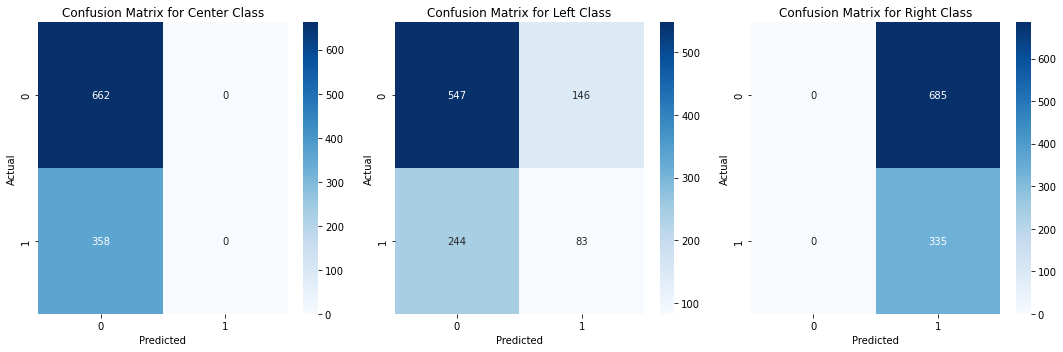

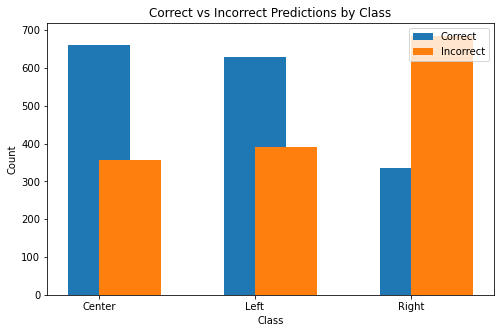

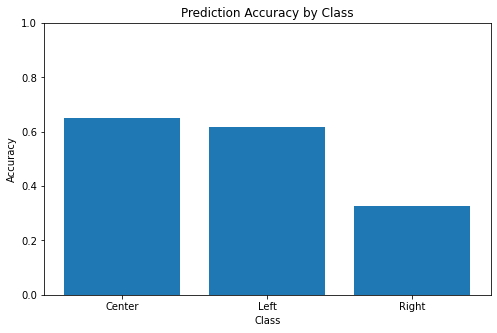

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrices for Center, Left, Right Classes Side by Side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for side-by-side matrices

for idx, class_name in enumerate(['center', 'left', 'right']):
    cm = confusion_matrix(df_results[f'actual_{class_name}'], df_results[f'predicted_{class_name}'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[idx])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'Confusion Matrix for {class_name.capitalize()} Class')

plt.tight_layout()
plt.show()


# Bar Plot of Correct vs Incorrect Predictions by Class

correct_counts = {
    'Center': (df_results['actual_center'] == df_results['predicted_center']).sum(),
    'Left': (df_results['actual_left'] == df_results['predicted_left']).sum(),
    'Right': (df_results['actual_right'] == df_results['predicted_right']).sum()
}

incorrect_counts = {
    'Center': (df_results['actual_center'] != df_results['predicted_center']).sum(),
    'Left': (df_results['actual_left'] != df_results['predicted_left']).sum(),
    'Right': (df_results['actual_right'] != df_results['predicted_right']).sum()
}

# Plotting
labels = list(correct_counts.keys())
correct = list(correct_counts.values())
incorrect = list(incorrect_counts.values())

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, correct, width=0.4, label='Correct', align='center')
plt.bar(x, incorrect, width=0.4, label='Incorrect', align='edge')
plt.xticks(x, labels)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Correct vs Incorrect Predictions by Class')
plt.legend()
plt.show()

# Accuracy by Class as Bar Plot
accuracy_by_class = {
    'Center': correct_counts['Center'] / (correct_counts['Center'] + incorrect_counts['Center']),
    'Left': correct_counts['Left'] / (correct_counts['Left'] + incorrect_counts['Left']),
    'Right': correct_counts['Right'] / (correct_counts['Right'] + incorrect_counts['Right'])
}

plt.figure(figsize=(8, 5))
plt.bar(accuracy_by_class.keys(), accuracy_by_class.values())
plt.ylim(0, 1)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy by Class')
plt.show()
